# Kinetic Energy Mean-Transient Decomposition

Decomposing the kinetic energy into time-mean and transient components.

## Theory

For a hydrostatic ocean model, like MOM5, the relevant kinetic energy per unit mass is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ {\rm TKE} = \left< {\rm KE} \right > {\stackrel{\rm{def}}{=}} \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right)\,\mathrm{d}t.$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g.,

$$ u = \bar{u} + u'.$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$${\rm TKE} = {\rm MKE} + {\rm EKE}.$$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'



import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr
import cmocean.cm as cmocean
import matplotlib.ticker as ticker
from dask.distributed import Client

In [2]:
# from tqdm import tqdm_notebook

Import cartopy to plot maps:

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [4]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33817/status,
Dashboard: /proxy/33817/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36645,Workers: 7
Dashboard: /proxy/33817/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:37397,Total threads: 4
Dashboard: /proxy/43115/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:36021,


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [5]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
iaf_cycle = '01deg_jra55v140_iaf'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

While not difficult to write down, this is fairly involved computation since to compute the eddy kinetic energy requires both the velocity and the mean of the velocity components.  Since the dataset is large, we want to avoid loading all of the velocity data into memory at the same time.

To calculate EKE, we need horizontal velocities $u$ and $v$, preferably saved at `1 daily` frequency (or perhaps `5 daily`). You can check whether your experiment has that kind of data:

### Example

For example, let's calculate the mean and eddy kinetic energy of this particular model run. Because the computations are very lengthy we will only load 1 month of daily velocity output.

(If you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`.)

Here we build datasets for the variables `u` and `v`.

### IAF CYCLE 1

In [6]:
lat_slice  = slice(-65.8, -64)
lon_slice  = slice(-255, -246)

depth_slice = slice(0,500)
u2 = cc.querying.getvar(iaf_cycle,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

v2 = cc.querying.getvar(iaf_cycle,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

2024-12-05 14:05:20,400 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-12-05 14:05:28,628 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2024-12-05 14:05:30,097 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2024-12-05 14:05:30,901 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


In [7]:
u_int = u2
v_int = v2

In [8]:
u_int_mean = u_int.mean('time')
v_int_mean = v_int.mean('time')

## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

In [9]:
### For the whole thing

In [10]:
u_int_transient = u_int - u_int_mean
v_int_transient = v_int - v_int_mean

In [11]:
dz = np.gradient(v_int_transient.st_ocean)[:, np.newaxis, np.newaxis]

In [12]:
## again, I have a slice, so don't have to integrate in z.
#EKE = (0.5*(u_transient**2 + v_transient**2)*dz).sum('st_ocean').mean('time')
EKE_int = (0.5*(u_int_transient**2 + v_int_transient**2)*dz).sum('st_ocean')

In [13]:
%%time
EKE_int = EKE_int.compute()

2024-12-05 14:16:21,963 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-12-05 14:18:58,826 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-12-05 14:20:13,842 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-12-05 14:20:17,949 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-12-05 14:20:30,333 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-05 14:20:36,745 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-05 14:20:43,347 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-12-05 14:22:36,568 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 13min 26s, sys: 28 s, total: 13min 54s
Wall time: 17min 45s


### 1. Make a box on the intrusion box!

In [14]:
# this was a test cut the data BOX 1
#lon_slice  = slice(-250.5, -249.5)
#lat_slice  = slice(-65.65, -65.2)
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

EKE_int_box = EKE_int.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


In [15]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE1 = (EKE_int_box*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

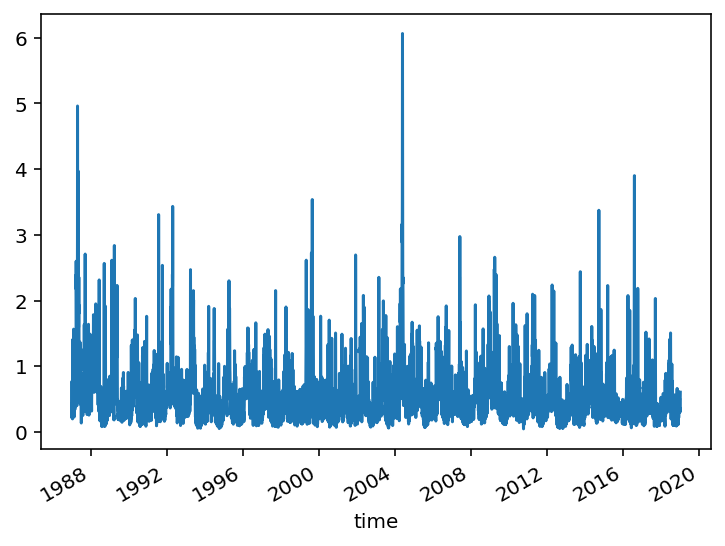

In [16]:
EKE1.plot();

In [17]:
EKE1=EKE1.load()

## Load EKE just at the slope, ekman region

In [18]:
EKE_int_slope = EKE_int

In [19]:
## this was designed for the areas of the slope where the average EKE was high
#lat_slice  = slice(-65.5, -63)
#lon_slice  = slice(-251, -246)
lon_slice  = slice(-251, -246) # best -251
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

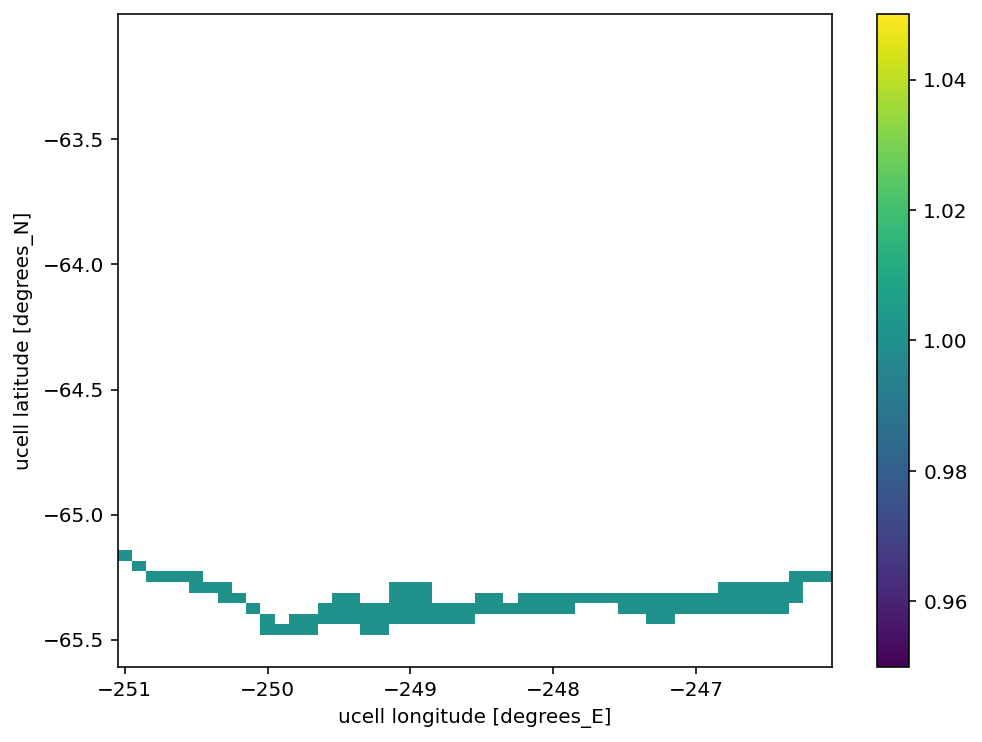

In [20]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [21]:
#apply the mask
EKE_int_slope = EKE_int_slope*region_mask
EKE_int_slope = EKE_int_slope.where(EKE_int_slope!=0)

In [22]:
#u_slope

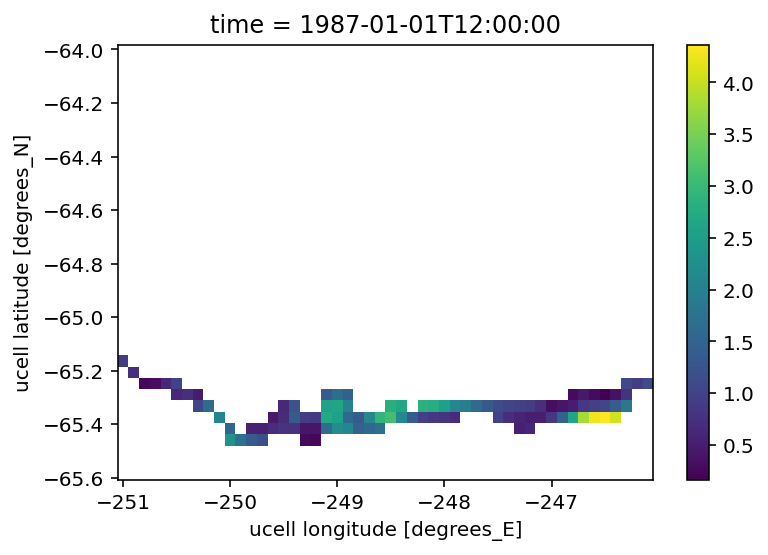

In [23]:
# first time step only:
EKE_int_slope[0,...].plot()

In [24]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE2 = (EKE_int_slope*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

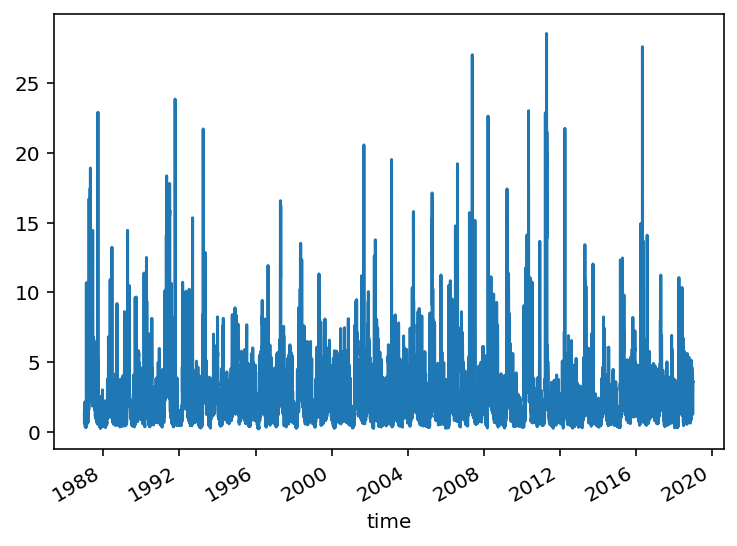

In [25]:
EKE2.plot();


In [26]:
EKE2=EKE2.load()

## Create the EKE time series at the location where the anomalies are strong. 

In [27]:
EKE_int_anom = EKE_int

In [28]:
lon_slice  = slice(-251.5, -249) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

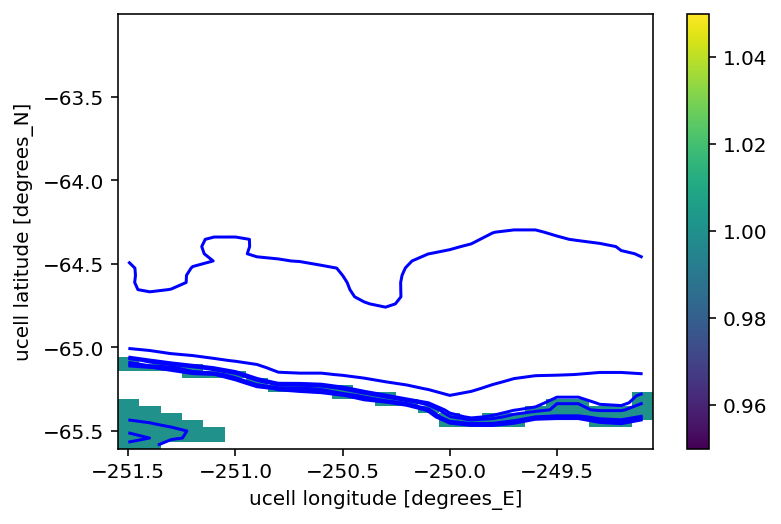

In [29]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [30]:
#apply the mask
EKE_int_anom = EKE_int_anom*region_mask
EKE_int_anom = EKE_int_anom.where(EKE_int_anom!=0)

In [31]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE3 = (EKE_int_anom*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

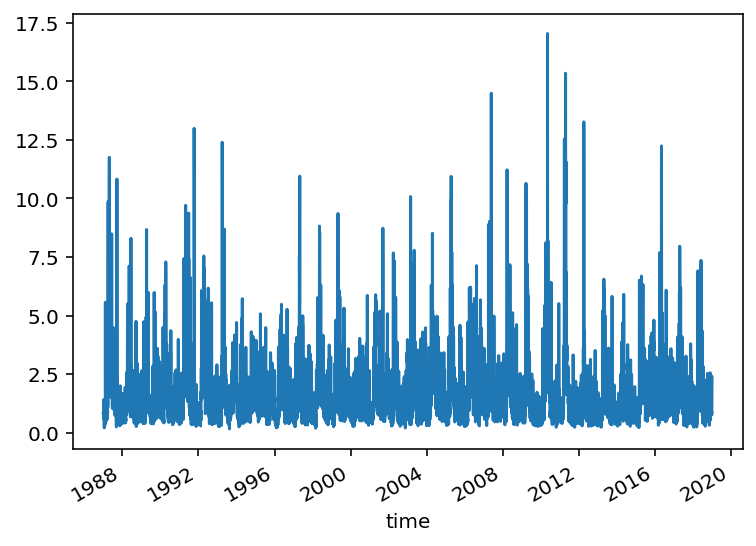

In [32]:
EKE3.plot();


In [33]:
EKE3=EKE3.load()

## Create the EKE time series at the same location of ASC SLOPE

In [34]:
EKE_int_slope = EKE_int

In [35]:
lon_slice  = slice(-252.5, -250) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

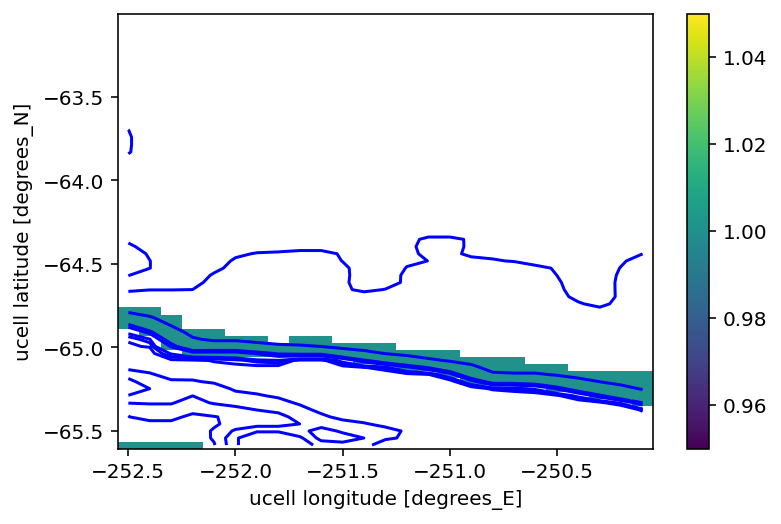

In [36]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U7002500m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [37]:
#apply the mask
EKE_int_slope = EKE_int_slope*region_mask
EKE_int_slope = EKE_int_slope.where(EKE_int_slope!=0)

In [38]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE4 = (EKE_int_slope*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

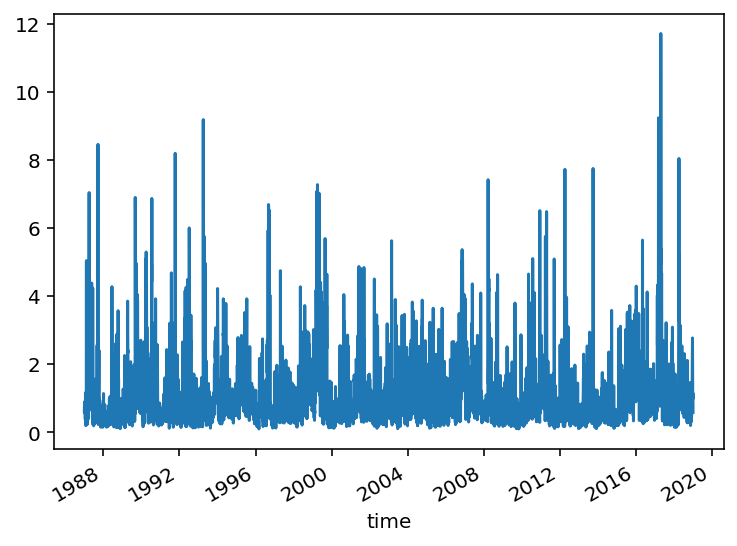

In [39]:
EKE4.plot();


In [40]:
EKE4=EKE4.load()

## Create Ekman on the same location of the ASC transect 

In [41]:
EKE_int_trans= EKE_int

In [42]:
lon_slice  = slice(-252.5, -250) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(expt,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

In [43]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -64.7 #64.8
lat1= -65.2 #65.1
lon0 = -252.6 #252.1
lon1 = -250.1 #250.1


In [44]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = EKE_int_trans.yu_ocean


# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[1],lats[0])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
EKE_int_trans = EKE_int_trans.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

EKE_int_trans = EKE_int_trans.load()

In [45]:
#u_transect

In [46]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
EKE5 = (EKE_int_trans*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [47]:
EKE5 = EKE5.load()

In [48]:
EKE_mth = EKE1.resample(time='1M').mean(dim='time')
EKE_mth2 = EKE2.resample(time='1M').mean(dim='time')
EKE_mth3 = EKE3.resample(time='1M').mean(dim='time')
EKE_mth4 = EKE4.resample(time='1M').mean(dim='time')
EKE_mth5 = EKE5.resample(time='1M').mean(dim='time')

In [49]:
## Note we need to first detrend the data:
EKE_d = detrend_dim(EKE_mth,'time')
EKE_dr = EKE_d.rolling(time=12, center=True).mean()
EKE_r = EKE_mth.rolling(time=12, center=True).mean()

## Note we need to first detrend the data:
EKE_d2 = detrend_dim(EKE_mth2,'time')
EKE_dr2 = EKE_d2.rolling(time=12, center=True).mean()
EKE_r2 = EKE_mth2.rolling(time=12, center=True).mean()

## Note we need to first detrend the data:
EKE_d3 = detrend_dim(EKE_mth3,'time')
EKE_dr3 = EKE_d3.rolling(time=12, center=True).mean()
EKE_r3 = EKE_mth3.rolling(time=12, center=True).mean()

## Note we need to first detrend the data:
EKE_d4 = detrend_dim(EKE_mth4,'time')
EKE_dr4 = EKE_d4.rolling(time=12, center=True).mean()
EKE_r4 = EKE_mth4.rolling(time=12, center=True).mean()

## Note we need to first detrend the data:
EKE_d5 = detrend_dim(EKE_mth5,'time')
EKE_dr5 = EKE_d5.rolling(time=12, center=True).mean()
EKE_r5 = EKE_mth5.rolling(time=12, center=True).mean()
## Note we need to first detrend the data:
#EKE_d = detrend_dim(EKE_mth_seasonal_removed,'time')
#EKE_dr = EKE_d.rolling(time=12, center=True).mean()
#EKE_r = EKE_mth_seasonal_removed.rolling(time=12, center=True).mean()

NameError: name 'detrend_dim' is not defined

## Correlation Formula

In [50]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or 
    for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    x = x.dropna(dim='time')
    y = y.dropna(dim='time')
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
     
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### PREPARE TEMPERATURE

In [51]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


2024-12-05 14:32:59,417 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:32:59,711 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:32:59,868 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:00,168 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:00,361 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:00,442 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:00,830 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:01,124 - distributed.utils_perf - WARNING - full garbage collections took

In [52]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

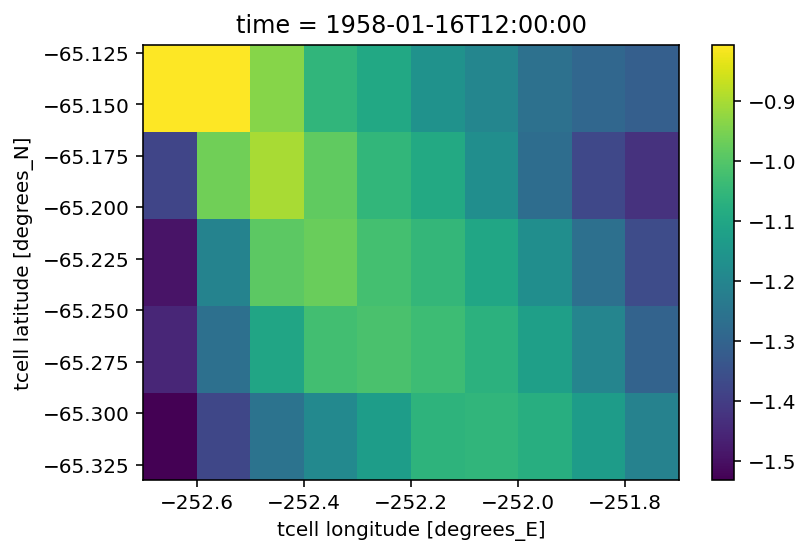

In [53]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [54]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [55]:
temp_400m = temp_400m.load()

2024-12-05 14:33:38,907 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [56]:
temp_teste = temp_400m.resample(time='1M').mean(dim='time')

##test if commenting this line out and summing the negative values go away

#### Detrend time series and apply rolling mean 

In [57]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_teste,'time')
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_400m_r = temp_teste.rolling(time=12, center=True).mean()



### ASC SPEED USING SLOPE

In [58]:
# depth limits chosen based on transects
depth_slice = slice(100, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
#lat_slice  = -65
lat_slice  = slice(-65.5, -63)
lon_slice  = slice(-255, -246)
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

2024-12-05 14:33:53,552 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:53,687 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:53,794 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:54,115 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:54,252 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:54,488 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:54,765 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:33:54,968 - distributed.utils_perf - WARNING - full garbage collections took

In [59]:
u_speed = u_speed.load()

In [60]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 200
zlevel2 = 500

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u_speed.yu_ocean,'xu_ocean':u_speed.xu_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'hu',master_session,n=1)
ht = ht.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))
# multiply by thickness to avg
u_speed = (u_speed*thickness).sum('st_ocean')/thickness.sum('st_ocean')

In [61]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-252.5, -250) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)

hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

## create the ASC time series at the same location of EKE

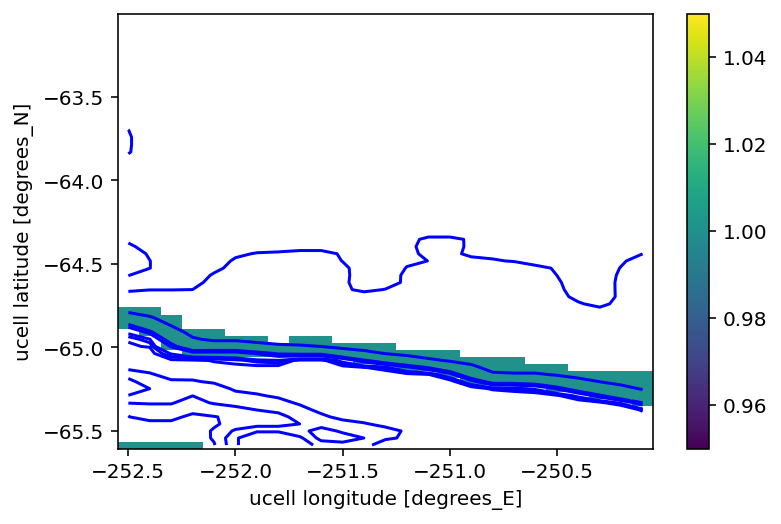

In [62]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U7002500m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')


In [63]:
#apply the mask
u_speed_off = u_speed*region_mask
u_speed_off = u_speed_off.where(u_speed_off!=0)

In [64]:
u_speed_slope = u_speed_off.mean('xu_ocean').mean('yu_ocean')

In [65]:
u_speed_slope = u_speed_slope.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


## Do the resampling

In [66]:
u_speed_teste = u_speed_slope.resample(time='1M').mean(dim='time')

#### Detrend time series both ASC heat flux X and speed time series

In [67]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
u_slope_td = detrend_dim(u_speed_teste,'time')

#### Apply Rolling mean to them 

In [68]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
u_slope_tdr = u_slope_td.rolling(time=12, center=True).mean()

In [69]:
u_slope_tr = u_speed_teste.rolling(time=12, center=True).mean()

### ASC SPEED USING TRANSECT LINE

In [70]:
# depth limits chosen based on transects
depth_slice = slice(0, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
#lat_slice  = -65
lat_slice  = slice(-66, -63)
lon_slice  = slice(-255, -248)
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

2024-12-05 14:34:47,421 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:47,678 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:47,698 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:47,813 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:47,831 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:48,404 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:48,455 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:34:48,526 - distributed.utils_perf - WARNING - full garbage collections took

In [71]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
u_slice = u_speed.sel(st_ocean=400,method='nearest').mean('time')
u_slice = u_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

2024-12-05 14:35:00,053 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


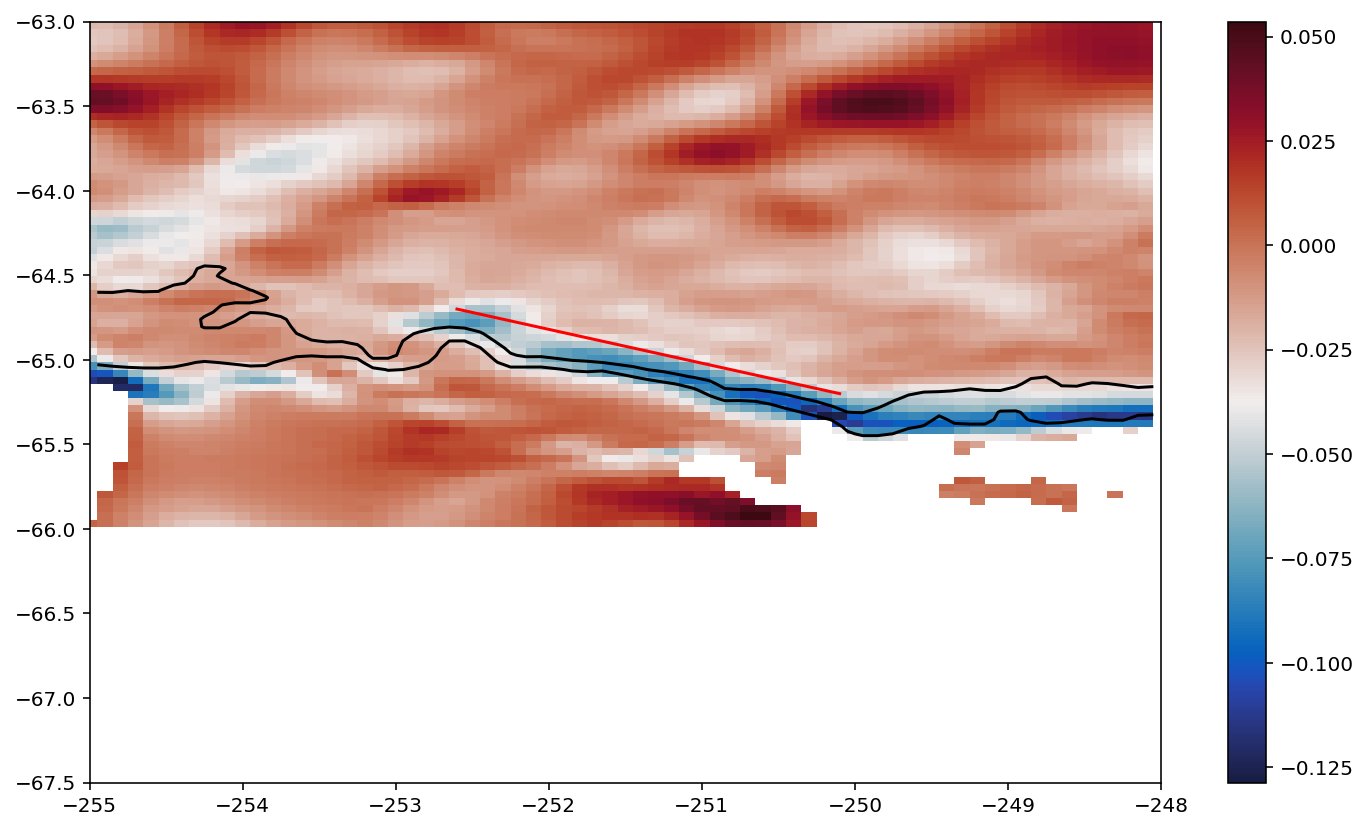

In [72]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -64.7 #64.8
lat1= -65.2 #65.1
lon0 = -252.6 #252.1
lon1 = -250.1 #250.1

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(u_slice.xu_ocean,u_slice.yu_ocean,u_slice, cmap=cmocean.balance)#,
#              vmin=-2,vmax=1)
plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63))
# plot bathymetry contours:
i=plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000],colors='k')

#save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
#plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [73]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean


# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[1],lats[0])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
u_transect = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

u_transect = u_transect.load()

2024-12-05 14:35:06,368 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [74]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 100
zlevel2 = 500

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u_speed.yu_ocean,'xu_ocean':u_speed.xu_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'hu',master_session,n=1)
ht = ht.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))
# multiply by thickness to avg
u_transect = (u_transect*thickness).sum('st_ocean')/thickness.sum('st_ocean')

In [75]:
u_transect = u_transect.mean('xu_ocean').mean('yu_ocean')

In [76]:
u_transect = u_transect.load() 

## Do the resampling

In [77]:
asc_teste = u_transect.resample(time='1M').mean(dim='time')

#### Detrend time series both ASC heat flux X and speed time series

In [78]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
u_speed_td = detrend_dim(asc_teste,'time')

#### Apply Rolling mean to them 

In [79]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
u_speed_tdr = u_speed_td.rolling(time=12, center=True).mean()

In [80]:
u_speed_tr = asc_teste.rolling(time=12, center=True).mean()

## SEA ICE CONCENTRATION

Here we load sea-ice monthly concentration. Note that aice_m is the monthly average of fractional ice area in each grid cell aka the concentration. To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does. So, let's load area_t from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [81]:
# cut the data BOX 1
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

var=cc.querying.getvar(iaf_cycle3,'aice_m' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time, decode_coords = False)
area_t = cc.querying.getvar(iaf_cycle3, 'area_t',master_session,n = 1)
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
ice_all=var.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
#ice_all=ice_all.mean(dim='time')
ice_all=ice_all.load()

2024-12-05 14:35:30,413 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:30,574 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:35,233 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:37,466 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:38,283 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:42,619 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:42,664 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:35:42,669 - distributed.utils_perf - WARNING - full garbage collections took

In [82]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-251, -246) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

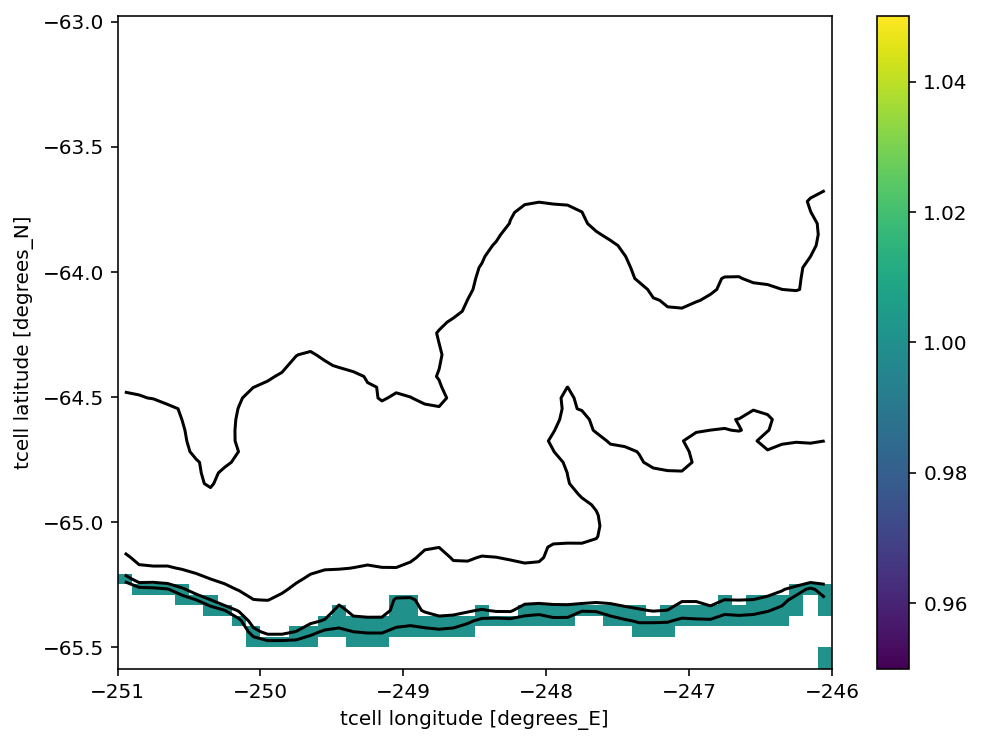

In [83]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_5001000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [84]:
#apply the mask
ice_all_off = ice_all*region_mask
ice_all_off = ice_all_off.where(ice_all_off!=0)

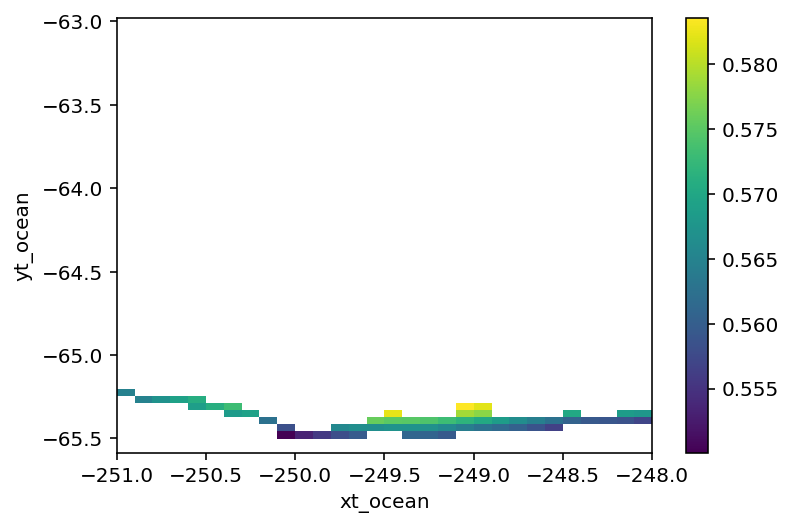

In [85]:
# first time step only:
iceice=ice_all_off.mean('time')
iceice.plot()
#ekman_con_off[0,...].plot()

In [86]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)



#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_t = area_t*region_mask

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
iceice_a = (ice_all_off*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum



In [87]:
ice_conc=iceice_a
ice_conc = ice_conc.load()

## Do the resampling

In [88]:
ice_teste = ice_conc.resample(time='1M').mean(dim='time')

### Detrend and rolling mean

In [89]:
# Note we need to first detrend the data:
ice_zad = detrend_dim(ice_teste,'time')
ice_zadr = ice_zad.rolling(time=12, center=True).mean()
ice_r = ice_teste.rolling(time=12, center=True).mean()


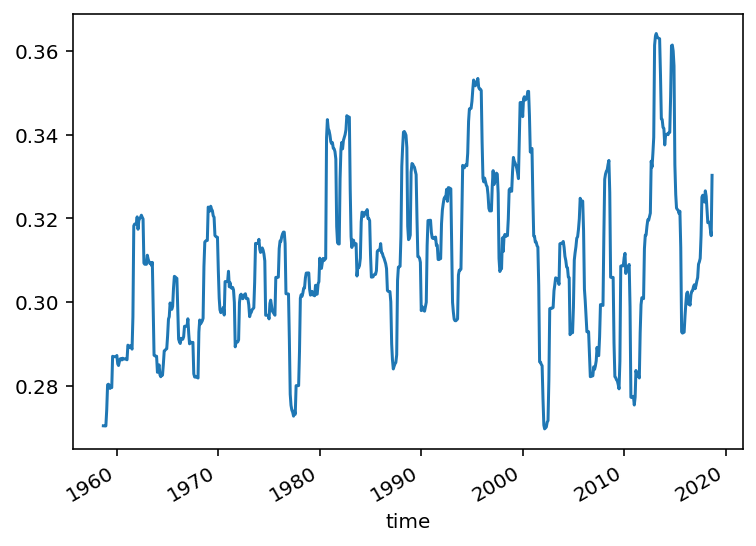

In [90]:
ice_r.plot()

## Ekman along the fine slope area 

In [91]:
lon_slice  = slice(-251, -245) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [92]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -245) # TRY SAME AS ISOPYCNALS
lat_slice  = slice(-67.5, -63)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

2024-12-05 14:36:08,307 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:36:19,927 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-05 14:36:19,965 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [93]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

2024-12-05 14:36:28,698 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [94]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [95]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


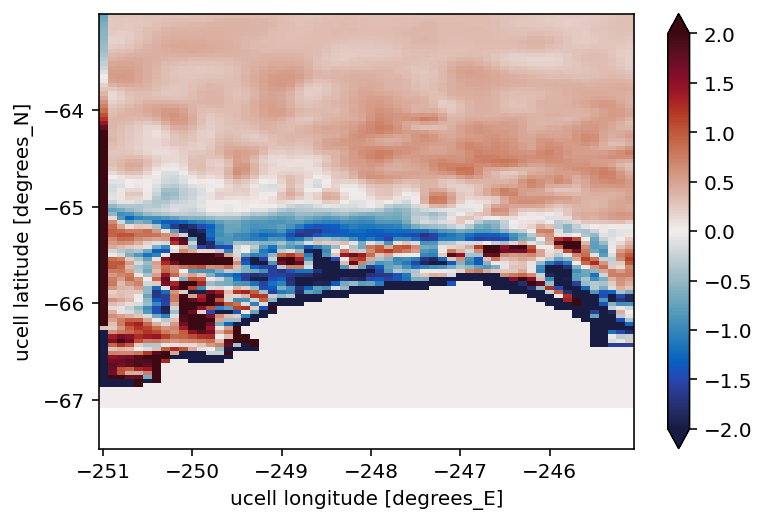

In [96]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [97]:
# cut the data BOX 1
#lon_slice  = slice(-252.3, -250.1) 
lon_slice  = slice(-251, -246) # best -251
#lon_slice  = slice(-253.5, -251.1)
lat_slice  = slice(-65.6, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

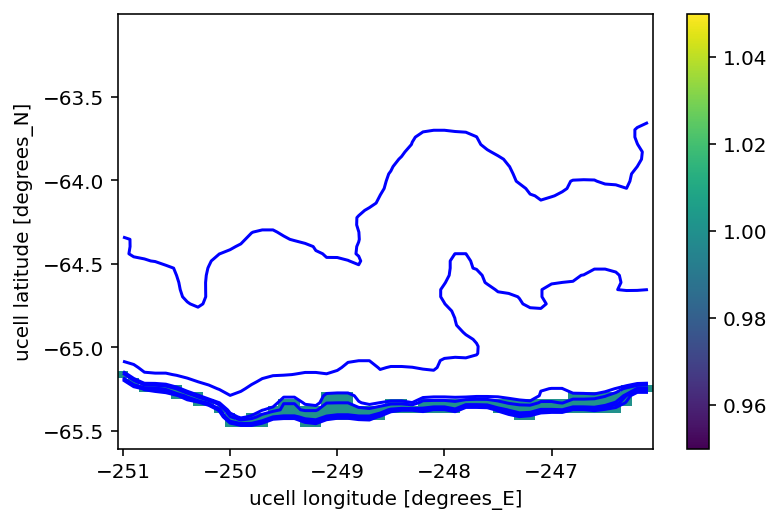

In [98]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U5001000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
#i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,2000,3000],colors='k')
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[550,600,650,900,1050,2000,3000],colors='b')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [99]:
#apply the mask
ekman_con_off = ekman_con*region_mask
ekman_con_off = ekman_con_off.where(ekman_con_off!=0)

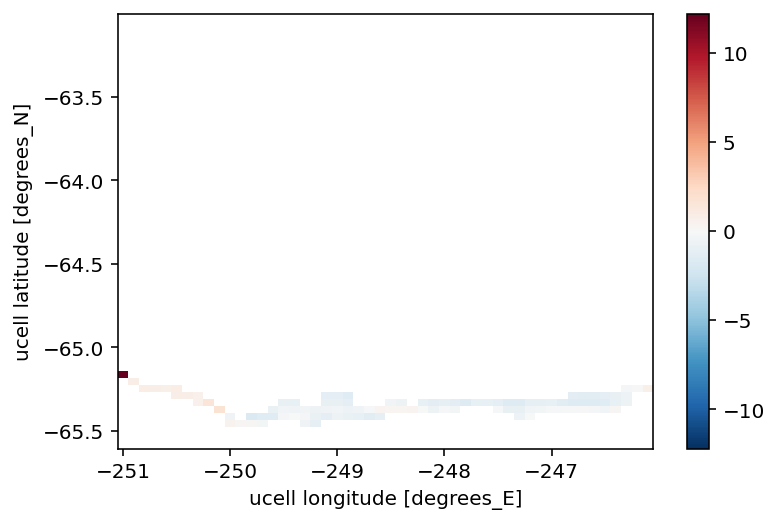

In [100]:
# first time step only:
ek=ekman_con_off.mean('time')
ek.plot()
#ekman_con_off[0,...].plot()

In [101]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
ekman_con_a = (ekman_con_off*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [102]:
#load the variable
ekman_con_a = ekman_con_a.load()

## Do the resampling

In [103]:
ekman_teste = ekman_con_a.resample(time='1M').mean(dim='time')

### Detrend and rolling mean

In [104]:
# Note we need to first detrend the data:
ekman_zad = detrend_dim(ekman_teste,'time')
ekman_zadr = ekman_zad.rolling(time=12, center=True).mean()
ekman_r = ekman_teste.rolling(time=12, center=True).mean()


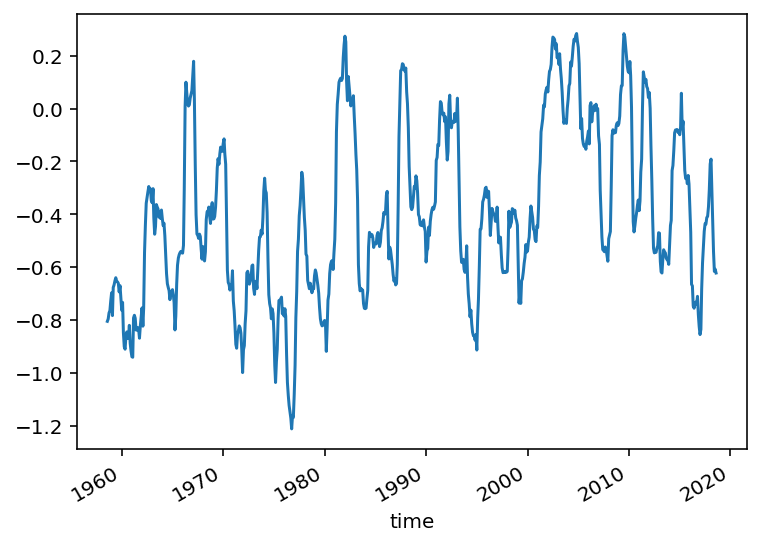

In [105]:
ekman_r.plot()

### CORRELATIONS WITH EKMAN AND ASC

In [111]:
# AA
s=16;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_r,ekman_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -15 :  <xarray.DataArray ()>
array(0.28564245)
lag -14 :  <xarray.DataArray ()>
array(0.30674836)
lag -13 :  <xarray.DataArray ()>
array(0.3305598)
lag -12 :  <xarray.DataArray ()>
array(0.35436939)
lag -11 :  <xarray.DataArray ()>
array(0.38085107)
lag -10 :  <xarray.DataArray ()>
array(0.41257736)
lag -9 :  <xarray.DataArray ()>
array(0.44182353)
lag -8 :  <xarray.DataArray ()>
array(0.46723543)
lag -7 :  <xarray.DataArray ()>
array(0.49227165)
lag -6 :  <xarray.DataArray ()>
array(0.51777993)
lag -5 :  <xarray.DataArray ()>
array(0.54241177)
lag -4 :  <xarray.DataArray ()>
array(0.58132464)
lag -3 :  <xarray.DataArray ()>
array(0.61815654)
lag -2 :  <xarray.DataArray ()>
array(0.64285163)
lag -1 :  <xarray.DataArray ()>
array(0.65522956)
lag 0 :  <xarray.DataArray ()>
array(0.66380266)


In [153]:
# AA
s=16;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr,ekman_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -15 :  <xarray.DataArray ()>
array(0.14313915)
lag -14 :  <xarray.DataArray ()>
array(0.17635985)
lag -13 :  <xarray.DataArray ()>
array(0.20953534)
lag -12 :  <xarray.DataArray ()>
array(0.24247712)
lag -11 :  <xarray.DataArray ()>
array(0.2725652)
lag -10 :  <xarray.DataArray ()>
array(0.29899339)
lag -9 :  <xarray.DataArray ()>
array(0.31757537)
lag -8 :  <xarray.DataArray ()>
array(0.32924302)
lag -7 :  <xarray.DataArray ()>
array(0.33229027)
lag -6 :  <xarray.DataArray ()>
array(0.32378345)
lag -5 :  <xarray.DataArray ()>
array(0.30653704)
lag -4 :  <xarray.DataArray ()>
array(0.28316127)
lag -3 :  <xarray.DataArray ()>
array(0.25167658)
lag -2 :  <xarray.DataArray ()>
array(0.21487125)
lag -1 :  <xarray.DataArray ()>
array(0.17239478)
lag 0 :  <xarray.DataArray ()>
array(0.12491333)


In [114]:
# AA
s=12;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_slope_tdr,ekman_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -11 :  <xarray.DataArray ()>
array(0.31175101)
lag -10 :  <xarray.DataArray ()>
array(0.29242237)
lag -9 :  <xarray.DataArray ()>
array(0.26762357)
lag -8 :  <xarray.DataArray ()>
array(0.2384928)
lag -7 :  <xarray.DataArray ()>
array(0.20493981)
lag -6 :  <xarray.DataArray ()>
array(0.16480628)
lag -5 :  <xarray.DataArray ()>
array(0.12076413)
lag -4 :  <xarray.DataArray ()>
array(0.07582004)
lag -3 :  <xarray.DataArray ()>
array(0.02988119)
lag -2 :  <xarray.DataArray ()>
array(-0.01507182)
lag -1 :  <xarray.DataArray ()>
array(-0.05765303)
lag 0 :  <xarray.DataArray ()>
array(-0.09708672)


### CORRELATIONS WITH Ekman vs Sea ice

In [115]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_zadr,ice_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.11643974)
lag -22 :  <xarray.DataArray ()>
array(-0.08539282)
lag -21 :  <xarray.DataArray ()>
array(-0.0534703)
lag -20 :  <xarray.DataArray ()>
array(-0.02280354)
lag -19 :  <xarray.DataArray ()>
array(0.00569582)
lag -18 :  <xarray.DataArray ()>
array(0.02538568)
lag -17 :  <xarray.DataArray ()>
array(0.04075695)
lag -16 :  <xarray.DataArray ()>
array(0.0546217)
lag -15 :  <xarray.DataArray ()>
array(0.0641575)
lag -14 :  <xarray.DataArray ()>
array(0.06818402)
lag -13 :  <xarray.DataArray ()>
array(0.06523871)
lag -12 :  <xarray.DataArray ()>
array(0.05496033)
lag -11 :  <xarray.DataArray ()>
array(0.03773935)
lag -10 :  <xarray.DataArray ()>
array(0.01738559)
lag -9 :  <xarray.DataArray ()>
array(-0.00272374)
lag -8 :  <xarray.DataArray ()>
array(-0.019949)
lag -7 :  <xarray.DataArray ()>
array(-0.03463975)
lag -6 :  <xarray.DataArray ()>
array(-0.04451621)
lag -5 :  <xarray.DataArray ()>
array(-0.05314461)
lag -4 :  <xarray.DataArray ()>


### CORRELATIONS WITH EKE vs TEMP

In [116]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,EKE_dr)
print(cor)

<xarray.DataArray ()>
array(0.41760544)


In [194]:
# AA
s=14;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr,temp_400m_r,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -13 :  <xarray.DataArray ()>
array(-0.24175437)
lag -12 :  <xarray.DataArray ()>
array(-0.25831523)
lag -11 :  <xarray.DataArray ()>
array(-0.27001739)
lag -10 :  <xarray.DataArray ()>
array(-0.27766255)
lag -9 :  <xarray.DataArray ()>
array(-0.27854602)
lag -8 :  <xarray.DataArray ()>
array(-0.27181859)
lag -7 :  <xarray.DataArray ()>
array(-0.25979059)
lag -6 :  <xarray.DataArray ()>
array(-0.2440543)
lag -5 :  <xarray.DataArray ()>
array(-0.22664979)
lag -4 :  <xarray.DataArray ()>
array(-0.20754426)
lag -3 :  <xarray.DataArray ()>
array(-0.1878783)
lag -2 :  <xarray.DataArray ()>
array(-0.16621736)
lag -1 :  <xarray.DataArray ()>
array(-0.14332457)
lag 0 :  <xarray.DataArray ()>
array(-0.11787254)


In [118]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr2,temp_400m_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(0.26029267)
lag -9 :  <xarray.DataArray ()>
array(0.26385049)
lag -8 :  <xarray.DataArray ()>
array(0.26377174)
lag -7 :  <xarray.DataArray ()>
array(0.26237944)
lag -6 :  <xarray.DataArray ()>
array(0.25943905)
lag -5 :  <xarray.DataArray ()>
array(0.25565936)
lag -4 :  <xarray.DataArray ()>
array(0.25569458)
lag -3 :  <xarray.DataArray ()>
array(0.25632469)
lag -2 :  <xarray.DataArray ()>
array(0.25653627)
lag -1 :  <xarray.DataArray ()>
array(0.2565341)
lag 0 :  <xarray.DataArray ()>
array(0.25690552)


In [185]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_r,EKE_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.18968373)
lag -22 :  <xarray.DataArray ()>
array(0.22611981)
lag -21 :  <xarray.DataArray ()>
array(0.26365769)
lag -20 :  <xarray.DataArray ()>
array(0.30173075)
lag -19 :  <xarray.DataArray ()>
array(0.34023173)
lag -18 :  <xarray.DataArray ()>
array(0.3772437)
lag -17 :  <xarray.DataArray ()>
array(0.41301506)
lag -16 :  <xarray.DataArray ()>
array(0.44741628)
lag -15 :  <xarray.DataArray ()>
array(0.47965074)
lag -14 :  <xarray.DataArray ()>
array(0.5082056)
lag -13 :  <xarray.DataArray ()>
array(0.53467353)
lag -12 :  <xarray.DataArray ()>
array(0.55953336)
lag -11 :  <xarray.DataArray ()>
array(0.58091637)
lag -10 :  <xarray.DataArray ()>
array(0.59843378)
lag -9 :  <xarray.DataArray ()>
array(0.61099274)
lag -8 :  <xarray.DataArray ()>
array(0.61882013)
lag -7 :  <xarray.DataArray ()>
array(0.62090733)
lag -6 :  <xarray.DataArray ()>
array(0.61656822)
lag -5 :  <xarray.DataArray ()>
array(0.603991)
lag -4 :  <xarray.DataArray ()>
array(0.

In [120]:
# AA
s=16;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr4,temp_400m_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -15 :  <xarray.DataArray ()>
array(0.17794324)
lag -14 :  <xarray.DataArray ()>
array(0.19577055)
lag -13 :  <xarray.DataArray ()>
array(0.20813275)
lag -12 :  <xarray.DataArray ()>
array(0.21531937)
lag -11 :  <xarray.DataArray ()>
array(0.21606145)
lag -10 :  <xarray.DataArray ()>
array(0.21030192)
lag -9 :  <xarray.DataArray ()>
array(0.19883806)
lag -8 :  <xarray.DataArray ()>
array(0.18155439)
lag -7 :  <xarray.DataArray ()>
array(0.15958174)
lag -6 :  <xarray.DataArray ()>
array(0.13290048)
lag -5 :  <xarray.DataArray ()>
array(0.10363781)
lag -4 :  <xarray.DataArray ()>
array(0.07482278)
lag -3 :  <xarray.DataArray ()>
array(0.04528709)
lag -2 :  <xarray.DataArray ()>
array(0.01491233)
lag -1 :  <xarray.DataArray ()>
array(-0.0163938)
lag 0 :  <xarray.DataArray ()>
array(-0.04854927)


In [121]:
# AA
s=16;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr5,temp_400m_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -15 :  <xarray.DataArray ()>
array(0.25498757)
lag -14 :  <xarray.DataArray ()>
array(0.26480035)
lag -13 :  <xarray.DataArray ()>
array(0.26805395)
lag -12 :  <xarray.DataArray ()>
array(0.26589919)
lag -11 :  <xarray.DataArray ()>
array(0.25628747)
lag -10 :  <xarray.DataArray ()>
array(0.23961182)
lag -9 :  <xarray.DataArray ()>
array(0.21648669)
lag -8 :  <xarray.DataArray ()>
array(0.18727672)
lag -7 :  <xarray.DataArray ()>
array(0.15567139)
lag -6 :  <xarray.DataArray ()>
array(0.12186509)
lag -5 :  <xarray.DataArray ()>
array(0.08765452)
lag -4 :  <xarray.DataArray ()>
array(0.05645524)
lag -3 :  <xarray.DataArray ()>
array(0.02556802)
lag -2 :  <xarray.DataArray ()>
array(-0.00512792)
lag -1 :  <xarray.DataArray ()>
array(-0.03616982)
lag 0 :  <xarray.DataArray ()>
array(-0.06782874)


### CORRELATIONS WITH EKE vs ASC

In [189]:
# AA
s=40;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr5,u_speed_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -39 :  <xarray.DataArray ()>
array(0.02058473)
lag -38 :  <xarray.DataArray ()>
array(0.0067738)
lag -37 :  <xarray.DataArray ()>
array(-0.0102461)
lag -36 :  <xarray.DataArray ()>
array(-0.0257619)
lag -35 :  <xarray.DataArray ()>
array(-0.04074736)
lag -34 :  <xarray.DataArray ()>
array(-0.05161956)
lag -33 :  <xarray.DataArray ()>
array(-0.06190828)
lag -32 :  <xarray.DataArray ()>
array(-0.07430535)
lag -31 :  <xarray.DataArray ()>
array(-0.08098277)
lag -30 :  <xarray.DataArray ()>
array(-0.08432284)
lag -29 :  <xarray.DataArray ()>
array(-0.08717948)
lag -28 :  <xarray.DataArray ()>
array(-0.08395318)
lag -27 :  <xarray.DataArray ()>
array(-0.07599632)
lag -26 :  <xarray.DataArray ()>
array(-0.06369684)
lag -25 :  <xarray.DataArray ()>
array(-0.04329568)
lag -24 :  <xarray.DataArray ()>
array(-0.01377281)
lag -23 :  <xarray.DataArray ()>
array(0.026707)
lag -22 :  <xarray.DataArray ()>
array(0.07198782)
lag -21 :  <xarray.DataArray ()>
array(0.12081491)
lag -20 :  <xarray.Dat

In [190]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr2,u_speed_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.01535266)
lag -22 :  <xarray.DataArray ()>
array(0.01168409)
lag -21 :  <xarray.DataArray ()>
array(0.03991491)
lag -20 :  <xarray.DataArray ()>
array(0.07300804)
lag -19 :  <xarray.DataArray ()>
array(0.10735258)
lag -18 :  <xarray.DataArray ()>
array(0.14402135)
lag -17 :  <xarray.DataArray ()>
array(0.18023873)
lag -16 :  <xarray.DataArray ()>
array(0.21284372)
lag -15 :  <xarray.DataArray ()>
array(0.24887283)
lag -14 :  <xarray.DataArray ()>
array(0.2839706)
lag -13 :  <xarray.DataArray ()>
array(0.31685703)
lag -12 :  <xarray.DataArray ()>
array(0.34352005)
lag -11 :  <xarray.DataArray ()>
array(0.35990695)
lag -10 :  <xarray.DataArray ()>
array(0.36155102)
lag -9 :  <xarray.DataArray ()>
array(0.35487479)
lag -8 :  <xarray.DataArray ()>
array(0.33802656)
lag -7 :  <xarray.DataArray ()>
array(0.31455614)
lag -6 :  <xarray.DataArray ()>
array(0.28531717)
lag -5 :  <xarray.DataArray ()>
array(0.25521315)
lag -4 :  <xarray.DataArray ()>
arra

In [174]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr3,u_speed_tr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.05389019)
lag -22 :  <xarray.DataArray ()>
array(0.07991016)
lag -21 :  <xarray.DataArray ()>
array(0.11060138)
lag -20 :  <xarray.DataArray ()>
array(0.14633312)
lag -19 :  <xarray.DataArray ()>
array(0.18282816)
lag -18 :  <xarray.DataArray ()>
array(0.22071807)
lag -17 :  <xarray.DataArray ()>
array(0.25619559)
lag -16 :  <xarray.DataArray ()>
array(0.28746269)
lag -15 :  <xarray.DataArray ()>
array(0.32243344)
lag -14 :  <xarray.DataArray ()>
array(0.35701931)
lag -13 :  <xarray.DataArray ()>
array(0.3889203)
lag -12 :  <xarray.DataArray ()>
array(0.41463065)
lag -11 :  <xarray.DataArray ()>
array(0.42981295)
lag -10 :  <xarray.DataArray ()>
array(0.43045613)
lag -9 :  <xarray.DataArray ()>
array(0.41843863)
lag -8 :  <xarray.DataArray ()>
array(0.39402533)
lag -7 :  <xarray.DataArray ()>
array(0.36259622)
lag -6 :  <xarray.DataArray ()>
array(0.32668115)
lag -5 :  <xarray.DataArray ()>
array(0.29226201)
lag -4 :  <xarray.DataArray ()>
array

In [301]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr4,u_speed_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.14312845)
lag -22 :  <xarray.DataArray ()>
array(-0.10308334)
lag -21 :  <xarray.DataArray ()>
array(-0.05611918)
lag -20 :  <xarray.DataArray ()>
array(-0.00172484)
lag -19 :  <xarray.DataArray ()>
array(0.0533937)
lag -18 :  <xarray.DataArray ()>
array(0.1066385)
lag -17 :  <xarray.DataArray ()>
array(0.15576331)
lag -16 :  <xarray.DataArray ()>
array(0.20299461)
lag -15 :  <xarray.DataArray ()>
array(0.25093261)
lag -14 :  <xarray.DataArray ()>
array(0.2961516)
lag -13 :  <xarray.DataArray ()>
array(0.33420878)
lag -12 :  <xarray.DataArray ()>
array(0.36317197)
lag -11 :  <xarray.DataArray ()>
array(0.38373652)
lag -10 :  <xarray.DataArray ()>
array(0.39749452)
lag -9 :  <xarray.DataArray ()>
array(0.40190131)
lag -8 :  <xarray.DataArray ()>
array(0.3940036)
lag -7 :  <xarray.DataArray ()>
array(0.37864118)
lag -6 :  <xarray.DataArray ()>
array(0.35849756)
lag -5 :  <xarray.DataArray ()>
array(0.3316133)
lag -4 :  <xarray.DataArray ()>
array

In [156]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr5,u_speed_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.026707)
lag -22 :  <xarray.DataArray ()>
array(0.07198782)
lag -21 :  <xarray.DataArray ()>
array(0.12081491)
lag -20 :  <xarray.DataArray ()>
array(0.1732813)
lag -19 :  <xarray.DataArray ()>
array(0.22413884)
lag -18 :  <xarray.DataArray ()>
array(0.27223091)
lag -17 :  <xarray.DataArray ()>
array(0.31874141)
lag -16 :  <xarray.DataArray ()>
array(0.35832969)
lag -15 :  <xarray.DataArray ()>
array(0.39442156)
lag -14 :  <xarray.DataArray ()>
array(0.42340536)
lag -13 :  <xarray.DataArray ()>
array(0.44434182)
lag -12 :  <xarray.DataArray ()>
array(0.45504699)
lag -11 :  <xarray.DataArray ()>
array(0.45403667)
lag -10 :  <xarray.DataArray ()>
array(0.44381652)
lag -9 :  <xarray.DataArray ()>
array(0.43071201)
lag -8 :  <xarray.DataArray ()>
array(0.40980847)
lag -7 :  <xarray.DataArray ()>
array(0.38168138)
lag -6 :  <xarray.DataArray ()>
array(0.34799184)
lag -5 :  <xarray.DataArray ()>
array(0.30417494)
lag -4 :  <xarray.DataArray ()>
array(0

In [125]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr,u_slope_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.21767957)
lag -22 :  <xarray.DataArray ()>
array(0.20713127)
lag -21 :  <xarray.DataArray ()>
array(0.19782974)
lag -20 :  <xarray.DataArray ()>
array(0.18819586)
lag -19 :  <xarray.DataArray ()>
array(0.17879848)
lag -18 :  <xarray.DataArray ()>
array(0.17298553)
lag -17 :  <xarray.DataArray ()>
array(0.16909667)
lag -16 :  <xarray.DataArray ()>
array(0.16538169)
lag -15 :  <xarray.DataArray ()>
array(0.16296433)
lag -14 :  <xarray.DataArray ()>
array(0.16135593)
lag -13 :  <xarray.DataArray ()>
array(0.1566704)
lag -12 :  <xarray.DataArray ()>
array(0.15000965)
lag -11 :  <xarray.DataArray ()>
array(0.14117249)
lag -10 :  <xarray.DataArray ()>
array(0.12718769)
lag -9 :  <xarray.DataArray ()>
array(0.1086257)
lag -8 :  <xarray.DataArray ()>
array(0.08887936)
lag -7 :  <xarray.DataArray ()>
array(0.06803371)
lag -6 :  <xarray.DataArray ()>
array(0.04435926)
lag -5 :  <xarray.DataArray ()>
array(0.0174413)
lag -4 :  <xarray.DataArray ()>
array(-

In [126]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr2,u_slope_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.11948145)
lag -22 :  <xarray.DataArray ()>
array(-0.11056656)
lag -21 :  <xarray.DataArray ()>
array(-0.09783536)
lag -20 :  <xarray.DataArray ()>
array(-0.07671906)
lag -19 :  <xarray.DataArray ()>
array(-0.05019239)
lag -18 :  <xarray.DataArray ()>
array(-0.01898598)
lag -17 :  <xarray.DataArray ()>
array(0.01695351)
lag -16 :  <xarray.DataArray ()>
array(0.05469007)
lag -15 :  <xarray.DataArray ()>
array(0.09978719)
lag -14 :  <xarray.DataArray ()>
array(0.14772348)
lag -13 :  <xarray.DataArray ()>
array(0.19669334)
lag -12 :  <xarray.DataArray ()>
array(0.24450115)
lag -11 :  <xarray.DataArray ()>
array(0.28840785)
lag -10 :  <xarray.DataArray ()>
array(0.32140835)
lag -9 :  <xarray.DataArray ()>
array(0.34892995)
lag -8 :  <xarray.DataArray ()>
array(0.36645153)
lag -7 :  <xarray.DataArray ()>
array(0.37691546)
lag -6 :  <xarray.DataArray ()>
array(0.38170898)
lag -5 :  <xarray.DataArray ()>
array(0.37987669)
lag -4 :  <xarray.DataArray ()

In [399]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr3,u_slope_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.1027623)
lag -22 :  <xarray.DataArray ()>
array(-0.0954661)
lag -21 :  <xarray.DataArray ()>
array(-0.08405813)
lag -20 :  <xarray.DataArray ()>
array(-0.06530109)
lag -19 :  <xarray.DataArray ()>
array(-0.04086455)
lag -18 :  <xarray.DataArray ()>
array(-0.01137975)
lag -17 :  <xarray.DataArray ()>
array(0.02309833)
lag -16 :  <xarray.DataArray ()>
array(0.05960911)
lag -15 :  <xarray.DataArray ()>
array(0.1022645)
lag -14 :  <xarray.DataArray ()>
array(0.14772652)
lag -13 :  <xarray.DataArray ()>
array(0.19338857)
lag -12 :  <xarray.DataArray ()>
array(0.23677484)
lag -11 :  <xarray.DataArray ()>
array(0.27561801)
lag -10 :  <xarray.DataArray ()>
array(0.30457956)
lag -9 :  <xarray.DataArray ()>
array(0.32710002)
lag -8 :  <xarray.DataArray ()>
array(0.33922692)
lag -7 :  <xarray.DataArray ()>
array(0.34367029)
lag -6 :  <xarray.DataArray ()>
array(0.34223897)
lag -5 :  <xarray.DataArray ()>
array(0.3355954)
lag -4 :  <xarray.DataArray ()>
ar

In [400]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(EKE_dr4,u_slope_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.14567491)
lag -22 :  <xarray.DataArray ()>
array(-0.11170859)
lag -21 :  <xarray.DataArray ()>
array(-0.07208405)
lag -20 :  <xarray.DataArray ()>
array(-0.02690939)
lag -19 :  <xarray.DataArray ()>
array(0.02055287)
lag -18 :  <xarray.DataArray ()>
array(0.06866221)
lag -17 :  <xarray.DataArray ()>
array(0.11320513)
lag -16 :  <xarray.DataArray ()>
array(0.15495742)
lag -15 :  <xarray.DataArray ()>
array(0.19681554)
lag -14 :  <xarray.DataArray ()>
array(0.23569716)
lag -13 :  <xarray.DataArray ()>
array(0.26853066)
lag -12 :  <xarray.DataArray ()>
array(0.29278431)
lag -11 :  <xarray.DataArray ()>
array(0.30840607)
lag -10 :  <xarray.DataArray ()>
array(0.31806913)
lag -9 :  <xarray.DataArray ()>
array(0.32239361)
lag -8 :  <xarray.DataArray ()>
array(0.31929398)
lag -7 :  <xarray.DataArray ()>
array(0.30937166)
lag -6 :  <xarray.DataArray ()>
array(0.29324663)
lag -5 :  <xarray.DataArray ()>
array(0.2717264)
lag -4 :  <xarray.DataArray ()>
a

### CORRELATIONS WITH TEMP vs ASC

In [127]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_slope_tdr,temp_400m_zadr)

In [128]:
print(cor)

<xarray.DataArray ()>
array(0.34134574)


In [158]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,u_slope_tr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.13412508)
lag -22 :  <xarray.DataArray ()>
array(0.13933782)
lag -21 :  <xarray.DataArray ()>
array(0.14462834)
lag -20 :  <xarray.DataArray ()>
array(0.15031665)
lag -19 :  <xarray.DataArray ()>
array(0.15637324)
lag -18 :  <xarray.DataArray ()>
array(0.1640969)
lag -17 :  <xarray.DataArray ()>
array(0.17361775)
lag -16 :  <xarray.DataArray ()>
array(0.18569951)
lag -15 :  <xarray.DataArray ()>
array(0.20031836)
lag -14 :  <xarray.DataArray ()>
array(0.21740028)
lag -13 :  <xarray.DataArray ()>
array(0.23653482)
lag -12 :  <xarray.DataArray ()>
array(0.25680651)
lag -11 :  <xarray.DataArray ()>
array(0.27821958)
lag -10 :  <xarray.DataArray ()>
array(0.3012784)
lag -9 :  <xarray.DataArray ()>
array(0.32598709)
lag -8 :  <xarray.DataArray ()>
array(0.35079513)
lag -7 :  <xarray.DataArray ()>
array(0.37433758)
lag -6 :  <xarray.DataArray ()>
array(0.39423413)
lag -5 :  <xarray.DataArray ()>
array(0.40875147)
lag -4 :  <xarray.DataArray ()>
array(

In [161]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr,u_speed_tdr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.10231221)
lag -22 :  <xarray.DataArray ()>
array(-0.11019682)
lag -21 :  <xarray.DataArray ()>
array(-0.11758346)
lag -20 :  <xarray.DataArray ()>
array(-0.12395443)
lag -19 :  <xarray.DataArray ()>
array(-0.12881197)
lag -18 :  <xarray.DataArray ()>
array(-0.13099017)
lag -17 :  <xarray.DataArray ()>
array(-0.12994912)
lag -16 :  <xarray.DataArray ()>
array(-0.12456736)
lag -15 :  <xarray.DataArray ()>
array(-0.11407966)
lag -14 :  <xarray.DataArray ()>
array(-0.09792089)
lag -13 :  <xarray.DataArray ()>
array(-0.07599534)
lag -12 :  <xarray.DataArray ()>
array(-0.04834555)
lag -11 :  <xarray.DataArray ()>
array(-0.01427681)
lag -10 :  <xarray.DataArray ()>
array(0.02709389)
lag -9 :  <xarray.DataArray ()>
array(0.07563337)
lag -8 :  <xarray.DataArray ()>
array(0.1296821)
lag -7 :  <xarray.DataArray ()>
array(0.18713455)
lag -6 :  <xarray.DataArray ()>
array(0.24481254)
lag -5 :  <xarray.DataArray ()>
array(0.29970916)
lag -4 :  <xarray.DataAr

## CORRELATIONS SEA ICE vs TEMP

In [106]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ice_zadr,temp_400m_zad,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.04331303)
lag -22 :  <xarray.DataArray ()>
array(0.02716023)
lag -21 :  <xarray.DataArray ()>
array(0.00717203)
lag -20 :  <xarray.DataArray ()>
array(-0.01582556)
lag -19 :  <xarray.DataArray ()>
array(-0.04129912)
lag -18 :  <xarray.DataArray ()>
array(-0.06657411)
lag -17 :  <xarray.DataArray ()>
array(-0.09561068)
lag -16 :  <xarray.DataArray ()>
array(-0.12662291)
lag -15 :  <xarray.DataArray ()>
array(-0.15646521)
lag -14 :  <xarray.DataArray ()>
array(-0.18408222)
lag -13 :  <xarray.DataArray ()>
array(-0.21090889)
lag -12 :  <xarray.DataArray ()>
array(-0.23648842)
lag -11 :  <xarray.DataArray ()>
array(-0.26068232)
lag -10 :  <xarray.DataArray ()>
array(-0.28254715)
lag -9 :  <xarray.DataArray ()>
array(-0.29497642)
lag -8 :  <xarray.DataArray ()>
array(-0.29909307)
lag -7 :  <xarray.DataArray ()>
array(-0.29760588)
lag -6 :  <xarray.DataArray ()>
array(-0.28872441)
lag -5 :  <xarray.DataArray ()>
array(-0.27194168)
lag -4 :  <xarray.Da

In [107]:
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ice_zadr,temp_400m_zad,
                                                       lagx=0, lagy=0)

In [109]:
pval

<xarray.DataArray ()>
array(1.99999594)

## CORRELATIONS SEA ICE vs ASC

In [107]:
# AA
s=12;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ice_zadr,u_slope_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -11 :  <xarray.DataArray ()>
array(-0.19321552)
lag -10 :  <xarray.DataArray ()>
array(-0.23146763)
lag -9 :  <xarray.DataArray ()>
array(-0.26795748)
lag -8 :  <xarray.DataArray ()>
array(-0.30282204)
lag -7 :  <xarray.DataArray ()>
array(-0.33073788)
lag -6 :  <xarray.DataArray ()>
array(-0.35084044)
lag -5 :  <xarray.DataArray ()>
array(-0.36077536)
lag -4 :  <xarray.DataArray ()>
array(-0.35947276)
lag -3 :  <xarray.DataArray ()>
array(-0.34686273)
lag -2 :  <xarray.DataArray ()>
array(-0.32865153)
lag -1 :  <xarray.DataArray ()>
array(-0.30634976)
lag 0 :  <xarray.DataArray ()>
array(-0.28071708)


In [131]:
# AA
s=12;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ice_zadr,u_speed_tdr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -11 :  <xarray.DataArray ()>
array(-0.35704238)
lag -10 :  <xarray.DataArray ()>
array(-0.38747577)
lag -9 :  <xarray.DataArray ()>
array(-0.4121283)
lag -8 :  <xarray.DataArray ()>
array(-0.43037706)
lag -7 :  <xarray.DataArray ()>
array(-0.43852332)
lag -6 :  <xarray.DataArray ()>
array(-0.43772662)
lag -5 :  <xarray.DataArray ()>
array(-0.42598504)
lag -4 :  <xarray.DataArray ()>
array(-0.40258349)
lag -3 :  <xarray.DataArray ()>
array(-0.36836909)
lag -2 :  <xarray.DataArray ()>
array(-0.32957941)
lag -1 :  <xarray.DataArray ()>
array(-0.28908661)
lag 0 :  <xarray.DataArray ()>
array(-0.24886962)


## CORRELATIONS SEA ICE vs EKE

In [198]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_zadr,EKE_dr5,
                                                       lagx=i, lagy=0)


    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.1385055)
lag -22 :  <xarray.DataArray ()>
array(0.12305354)
lag -21 :  <xarray.DataArray ()>
array(0.10351632)
lag -20 :  <xarray.DataArray ()>
array(0.08598191)
lag -19 :  <xarray.DataArray ()>
array(0.06877001)
lag -18 :  <xarray.DataArray ()>
array(0.05323709)
lag -17 :  <xarray.DataArray ()>
array(0.0387548)
lag -16 :  <xarray.DataArray ()>
array(0.02078738)
lag -15 :  <xarray.DataArray ()>
array(0.0024445)
lag -14 :  <xarray.DataArray ()>
array(-0.01363386)
lag -13 :  <xarray.DataArray ()>
array(-0.03308219)
lag -12 :  <xarray.DataArray ()>
array(-0.05697338)
lag -11 :  <xarray.DataArray ()>
array(-0.07802647)
lag -10 :  <xarray.DataArray ()>
array(-0.09363099)
lag -9 :  <xarray.DataArray ()>
array(-0.10466216)
lag -8 :  <xarray.DataArray ()>
array(-0.11794626)
lag -7 :  <xarray.DataArray ()>
array(-0.13277846)
lag -6 :  <xarray.DataArray ()>
array(-0.14670543)
lag -5 :  <xarray.DataArray ()>
array(-0.15971472)
lag -4 :  <xarray.DataArray (

In [116]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(u_slope_tdr,ekman_zadr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(0.2277251)
lag -22 :  <xarray.DataArray ()>
array(0.24465949)
lag -21 :  <xarray.DataArray ()>
array(0.26251416)
lag -20 :  <xarray.DataArray ()>
array(0.2798814)
lag -19 :  <xarray.DataArray ()>
array(0.29613491)
lag -18 :  <xarray.DataArray ()>
array(0.31477295)
lag -17 :  <xarray.DataArray ()>
array(0.33172249)
lag -16 :  <xarray.DataArray ()>
array(0.34350244)
lag -15 :  <xarray.DataArray ()>
array(0.35116686)
lag -14 :  <xarray.DataArray ()>
array(0.35431922)
lag -13 :  <xarray.DataArray ()>
array(0.35128574)
lag -12 :  <xarray.DataArray ()>
array(0.34258029)
lag -11 :  <xarray.DataArray ()>
array(0.3282869)
lag -10 :  <xarray.DataArray ()>
array(0.31089523)
lag -9 :  <xarray.DataArray ()>
array(0.2880491)
lag -8 :  <xarray.DataArray ()>
array(0.26084369)
lag -7 :  <xarray.DataArray ()>
array(0.22921729)
lag -6 :  <xarray.DataArray ()>
array(0.19087359)
lag -5 :  <xarray.DataArray ()>
array(0.14838841)
lag -4 :  <xarray.DataArray ()>
array(0.

In [165]:
# AA
s=24;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(ekman_zadr,u_speed_tdr,
                                                       lagx=i, lagy=0)

    print('lag', i+1, ': ',cor)

lag -23 :  <xarray.DataArray ()>
array(-0.05549121)
lag -22 :  <xarray.DataArray ()>
array(-0.04249499)
lag -21 :  <xarray.DataArray ()>
array(-0.02548067)
lag -20 :  <xarray.DataArray ()>
array(-0.00584027)
lag -19 :  <xarray.DataArray ()>
array(0.01735442)
lag -18 :  <xarray.DataArray ()>
array(0.04714221)
lag -17 :  <xarray.DataArray ()>
array(0.07947565)
lag -16 :  <xarray.DataArray ()>
array(0.11092061)
lag -15 :  <xarray.DataArray ()>
array(0.14344451)
lag -14 :  <xarray.DataArray ()>
array(0.1763684)
lag -13 :  <xarray.DataArray ()>
array(0.20926156)
lag -12 :  <xarray.DataArray ()>
array(0.24193173)
lag -11 :  <xarray.DataArray ()>
array(0.27176985)
lag -10 :  <xarray.DataArray ()>
array(0.29797847)
lag -9 :  <xarray.DataArray ()>
array(0.31639583)
lag -8 :  <xarray.DataArray ()>
array(0.32794971)
lag -7 :  <xarray.DataArray ()>
array(0.33095578)
lag -6 :  <xarray.DataArray ()>
array(0.32251208)
lag -5 :  <xarray.DataArray ()>
array(0.30539439)
lag -4 :  <xarray.DataArray ()>
a

### PLOT TIME SERIES FOR FIGURE 

In [118]:
eke_sh=EKE_r.shift(time=9).dropna(dim='time')

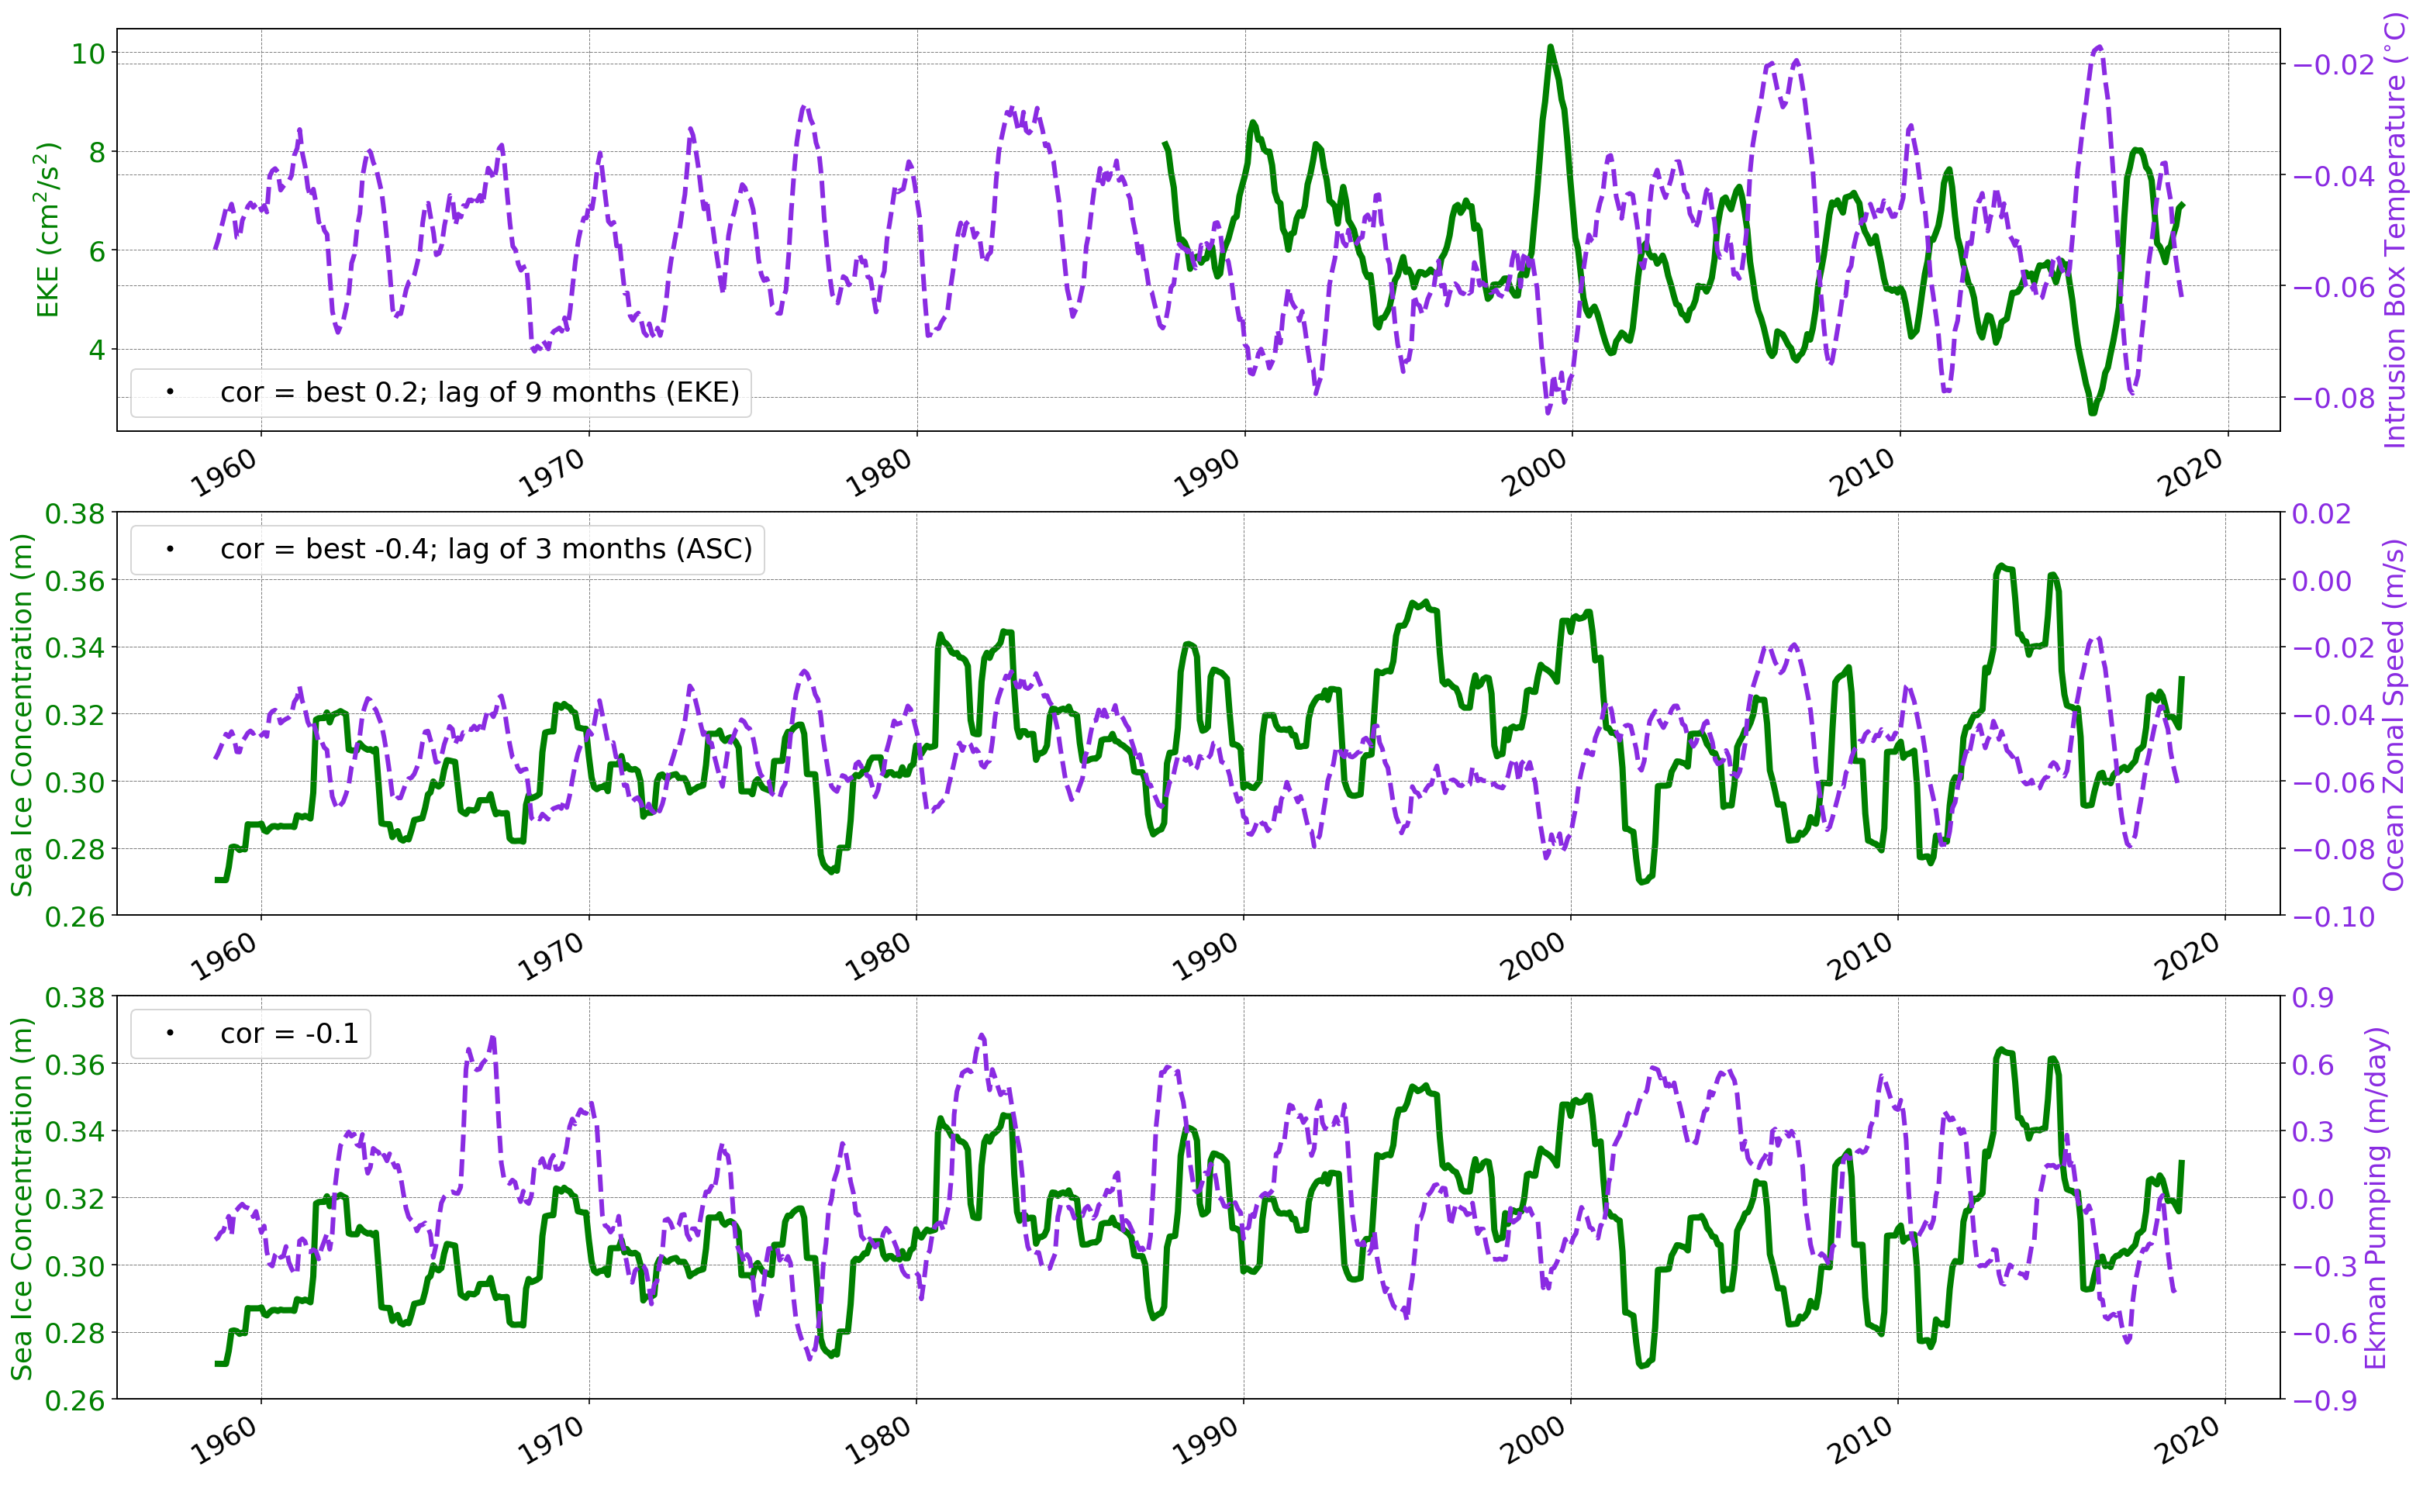

In [367]:
fontsize=18
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)


ax1 = plt.subplot(4, 1, 1)
EKE_r.plot(color='green',linewidth=4)
ax1.set_ylabel('EKE (cm$^{2}$/s$^{2}$)', fontsize=fontsize,color='green')
ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
plt.title('')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.ylim([0.003,0.01])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
u_speed_tr.plot(color='blueviolet',linestyle='--',linewidth=3)
#temp_400m_r.plot(color='blueviolet',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Intrusion Box Temperature ($^{\circ}$C)', fontsize=fontsize, color='blueviolet')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = best 0.2; lag of 9 months (EKE)')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
#plt.ylim([-1.6,-0.2])

ax1 = plt.subplot(4, 1, 2)
ice_r.plot(color='green',linewidth=4)
ax1.set_ylabel('Sea Ice Concentration (m)', fontsize=fontsize,color='green')
ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
plt.title('')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([0.26,0.38])
ax1.yaxis.set_major_locator(plt.MaxNLocator(7))
ax1.set_yticks(np.linspace(0.26,0.38, 7))

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
u_speed_tr.plot(color='blueviolet',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Ocean Zonal Speed (m/s)', fontsize=fontsize, color='blueviolet')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = best -0.4; lag of 3 months (ASC)')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([-0.1,0.02])
ax2.yaxis.set_major_locator(plt.MaxNLocator(7))
ax2.set_yticks(np.linspace(-0.1,0.02, 7))

ax1 = plt.subplot(4, 1, 3)
ice_r.plot(color='green',linewidth=4)
ax1.set_ylabel('Sea Ice Concentration (m)', fontsize=fontsize,color='green')
ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
plt.title('')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([0.26,0.38])
ax1.yaxis.set_major_locator(plt.MaxNLocator(7))
ax1.set_yticks(np.linspace(0.26,0.38, 7))

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
ekman_zadr.plot(color='blueviolet',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Ekman Pumping (m/day)', fontsize=fontsize, color='blueviolet')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
#sets the number of ticks in each side
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = -0.1')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([-0.8,0.8])
# set y-tick values and labels for first axis
ax2.yaxis.set_major_locator(plt.MaxNLocator(7))
ax2.set_yticks(np.linspace(-0.9, 0.9, 7))

#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
#filestr = figdir+'/fig_EKE_timeseries_for_reviewer.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Make the separate plot for temp and sea ice concentration correlation

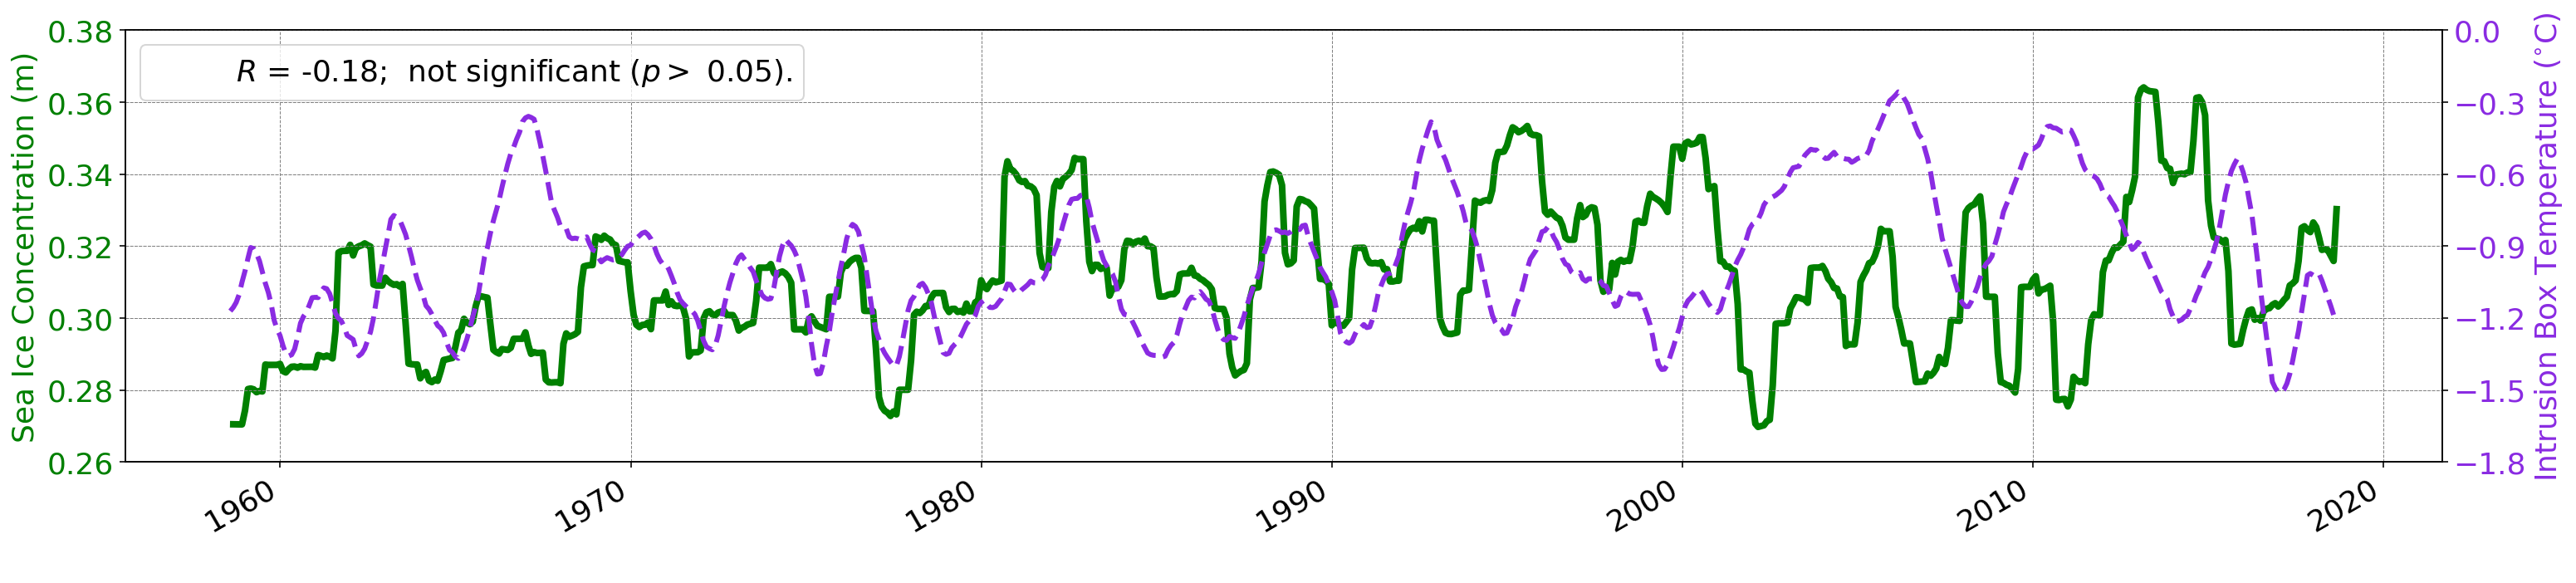

In [112]:
fontsize=18
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
ice_r.plot(color='green',linewidth=4)
ax1.set_ylabel('Sea Ice Concentration (m)', fontsize=fontsize,color='green')
ax1.tick_params(axis='y', labelcolor='green',labelsize=fontsize)

#sets the number of ticks in each side
ax1.yaxis.set_major_locator(plt.MaxNLocator(7))
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
plt.title('')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([0.26,0.38])
# set y-tick values and labels for first axis
ax1.set_yticks(np.linspace(0.26,0.38, 7))

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
temp_400m_r.plot(color='blueviolet',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Intrusion Box Temperature ($^{\circ}$C)', fontsize=fontsize, color='blueviolet')
ax2.tick_params(axis='x',labelsize=fontsize)
#sets the number of ticks in each side
ax2.yaxis.set_major_locator(plt.MaxNLocator(7))
ax2.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',linestyle='none',label='$R$ = -0.18;  not significant ($p >$ 0.05).')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([-1.6,-0.2])
# set y-tick values and labels for first axis
ax2.set_yticks(np.linspace(-1.8, 0, 7))

figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig_sea-ice_temp_time_series.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')